In [31]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# 1. Carregamento e Limpeza Inicial

# Carregar o dataset
df = pd.read_csv('heart.csv')

# Limpar espaços em branco 
df.columns = df.columns.str.strip()

# Substituir os valores '0' em Cholesterol por NaN 
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)


In [33]:
# 2. Separação de Features e Identificação de Tipos de Colunas 

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# FastingBS é numérica, mas binária, então tratamos como categórica
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Convertendo 'FastingBS' para string para garantir que o OneHotEncoder a trate como categoria
X['FastingBS'] = X['FastingBS'].astype(str)

print(f"Features numéricas identificadas: {numerical_features}")
print(f"Features categóricas identificadas: {categorical_features}\n")

Features numéricas identificadas: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Features categóricas identificadas: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']



In [34]:
# 3. Construção do Pipeline de Pré-processamento

# Pipeline para features NUMÉRICAS 
# Imputer é uma técnica que encontramos, do sklearn, para tratar dados ausentes.
# Ele ve quais são os X vizinhos mais proximos de uma instância que tem um dado faltante, e atribui a 
# média desses 5 valores a ele.
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Pipeline para features CATEGÓRICAS 
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

# Combinar os dois pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [35]:
# 4. Aplicação do Pipeline
X_processed = preprocessor.fit_transform(X)


In [36]:
# 5. Visualização do Resultado 
processed_cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
new_column_names = numerical_features + list(processed_cat_cols)

df_processed = pd.DataFrame(X_processed, columns=new_column_names)

print("- Dados Após o Pré-processamento ")
print(f"Shape dos dados processados: {df_processed.shape}")
print("Visualização das 5 primeiras linhas dos dados prontos para o modelo:")
print(df_processed.head())

- Dados Após o Pré-processamento 
Shape dos dados processados: (918, 18)
Visualização das 5 primeiras linhas dos dados prontos para o modelo:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak  Sex_ M    \
0 -1.433140   0.410909     0.801850  1.382928 -0.832432       1.0   
1 -0.478484   1.491752    -1.190272  0.754157  0.105664       0.0   
2 -1.751359  -0.129513     0.692192 -1.525138 -0.832432       1.0   
3 -0.584556   0.302825    -0.568876 -1.132156  0.574711       0.0   
4  0.051881   0.951331    -0.916127 -0.581981 -0.832432       1.0   

   ChestPainType_ ASY            ChestPainType_ ATA            \
0                           0.0                           1.0   
1                           0.0                           0.0   
2                           0.0                           1.0   
3                           1.0                           0.0   
4                           0.0                           0.0   

   ChestPainType_ NAP            ChestPainType_ TA  

In [37]:
# 6. Divisão dos Dados, Treinamento e Avaliação do Modelo 

# 6.1 Divisão dos Dados em Treino e Teste
# Vamos usar o 'X_processed' gerado pelo pipeline e o 'y' original.
# stratify=y garante que a proporção de pacientes doentes e não doentes seja a mesma nos 
# conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print("- Dados divididos em conjuntos de treino e teste")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras\n")

- Dados divididos em conjuntos de treino e teste
Tamanho do conjunto de treino: 734 amostras
Tamanho do conjunto de teste: 184 amostras



In [38]:
# 6.2 Treinamento do Modelo KNN
# Instanciamos o modelo. Vamos usar k=5 como um bom ponto de partida.
knn_model = KNeighborsClassifier(n_neighbors=5)

# Treinamos o modelo usando os dados de treino
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [39]:
# 6.3 Previsões e Avaliação no Conjunto de Teste

y_pred = knn_model.predict(X_test)

# Calcular as métricas de performance comparando as previsões (y_pred) com os valores reais (y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("- Métricas de Avaliação do Modelo KNN ")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}\n")

print("- Relatório de Classificação ")
print(classification_report(y_test, y_pred, target_names=['Não Doente (0)', 'Doente (1)']))



- Métricas de Avaliação do Modelo KNN 
Acurácia: 0.8696
Precisão: 0.8900
Recall: 0.8725
F1-Score: 0.8812

- Relatório de Classificação 
                precision    recall  f1-score   support

Não Doente (0)       0.85      0.87      0.86        82
    Doente (1)       0.89      0.87      0.88       102

      accuracy                           0.87       184
     macro avg       0.87      0.87      0.87       184
  weighted avg       0.87      0.87      0.87       184



- Matriz de Confusão


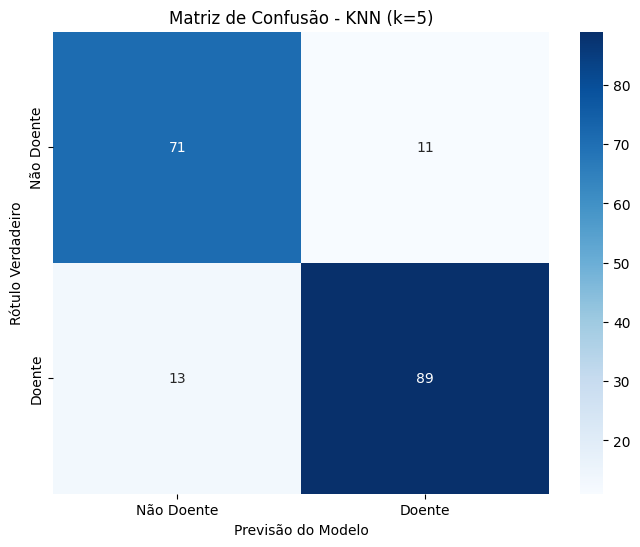

In [40]:
# 6.4 Visualização da Matriz de Confusão
# A Matriz de Confusão nos ajuda a visualizar os acertos e erros do modelo, e entender as estatísticas
# citadas acima.
print("- Matriz de Confusão")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Doente', 'Doente'], 
            yticklabels=['Não Doente', 'Doente'])
            
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão - KNN (k=5)')
plt.show()